<a href="https://colab.research.google.com/github/PankajShukla/Stock-Market-Trend-Prediction/blob/main/Trend_Classification_Stock_Market_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhance an existing trading strategy by developing a more robust machine learning algorithm

# Library installation

In [ ]:
!pip install Keras

In [241]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import datetime
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks

from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_column", 500)

from google.colab import drive

# Setting up Drive for pulling data

In [245]:
drive.mount('/content/drive', force_remount=True)
DrivePath = input('Enter Drive Path Location where the file is stored.')

Mounted at /content/drive
Enter Drive Path Location where the file is stored./content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/


In [ ]:
# /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/

# Loading the Dataset

In [246]:
cwdir = os.getcwd()
filename = 'Input_data.csv'
filename = os.path.join(cwdir,DrivePath,filename)

In [247]:
df = pd.read_csv(filename)
df.head(3)

,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final
0,04/01/11 9:55,6150.10,6150.10,6136.00,6136.30,-283.26,-0.01,2.53,1,0
1,04/01/11 10:00,6135.90,6145.75,6134.85,6145.40,-240.60,0.00,2.57,1,0
2,04/01/11 10:05,6145.55,6150.00,6145.20,6148.25,-161.85,0.00,2.24,1,0


# Data Exploration, Data Cleaning and Metrics Derivation

In [248]:
df['timestamp'] = pd.to_datetime(df['Date-Time'], format='%d/%m/%y %H:%M')

df['date'] = df['timestamp'].dt.date

df['dayofweek'] = df['timestamp'].dt.weekday
df['dayofmonth'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.quarter
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

df['prev_Close'] = df['Close'].shift(1)
df['prev_Close'].fillna(df['Close'], inplace=True)

df['TR1'] = df['High']-df['Low']
df['TR2'] = df['High']-df['prev_Close']
df['TR3'] = df['Low'] -df['prev_Close']

df['TR'] = df[['TR1','TR2','TR3']].max(axis=1)

df['ATR'] = df['Close'].rolling(14, min_periods=1).mean()
df['SMA_50'] = df['Close'].rolling(50, min_periods=1).mean()
df['EMA_50'] = df['Close'].ewm(com=2).mean()

In [249]:
df_reading_cnt = df.groupby('date')['timestamp'].nunique().reset_index()
df_reading_cnt.describe()

,timestamp
count,3292.000000
mean,74.957169
std,1.039038
min,26.000000
25%,75.000000
50%,75.000000
75%,75.000000
max,75.000000


In [250]:
df.year.unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024], dtype=int32)

In [251]:
df_reading_cnt[df_reading_cnt.timestamp<68].date.unique()

array([datetime.date(2015, 12, 21), datetime.date(2020, 3, 13),
       datetime.date(2021, 2, 24), datetime.date(2021, 12, 6),
       datetime.date(2023, 11, 6)], dtype=object)

In [252]:
df.Trend_final.value_counts()

Trend_final
0    174990
1     71769
Name: count, dtype: int64

In [253]:
df.drop(columns=['prev_Close', 'TR1', 'TR2', 'TR3'], inplace=True)

In [254]:
df.shape, df[~((df.Trend_initial==1) & (df.Trend_final==0))].shape, df[(df.Trend_initial==1) & (df.Trend_final==0)].shape

((246759, 24), (210475, 24), (36284, 24))

In [255]:
df = df[~((df.Trend_initial==1) & (df.Trend_final==0))]

In [256]:
df.Trend_final.value_counts()

Trend_final
0    138706
1     71769
Name: count, dtype: int64

# Correlation Plot

<Axes: >

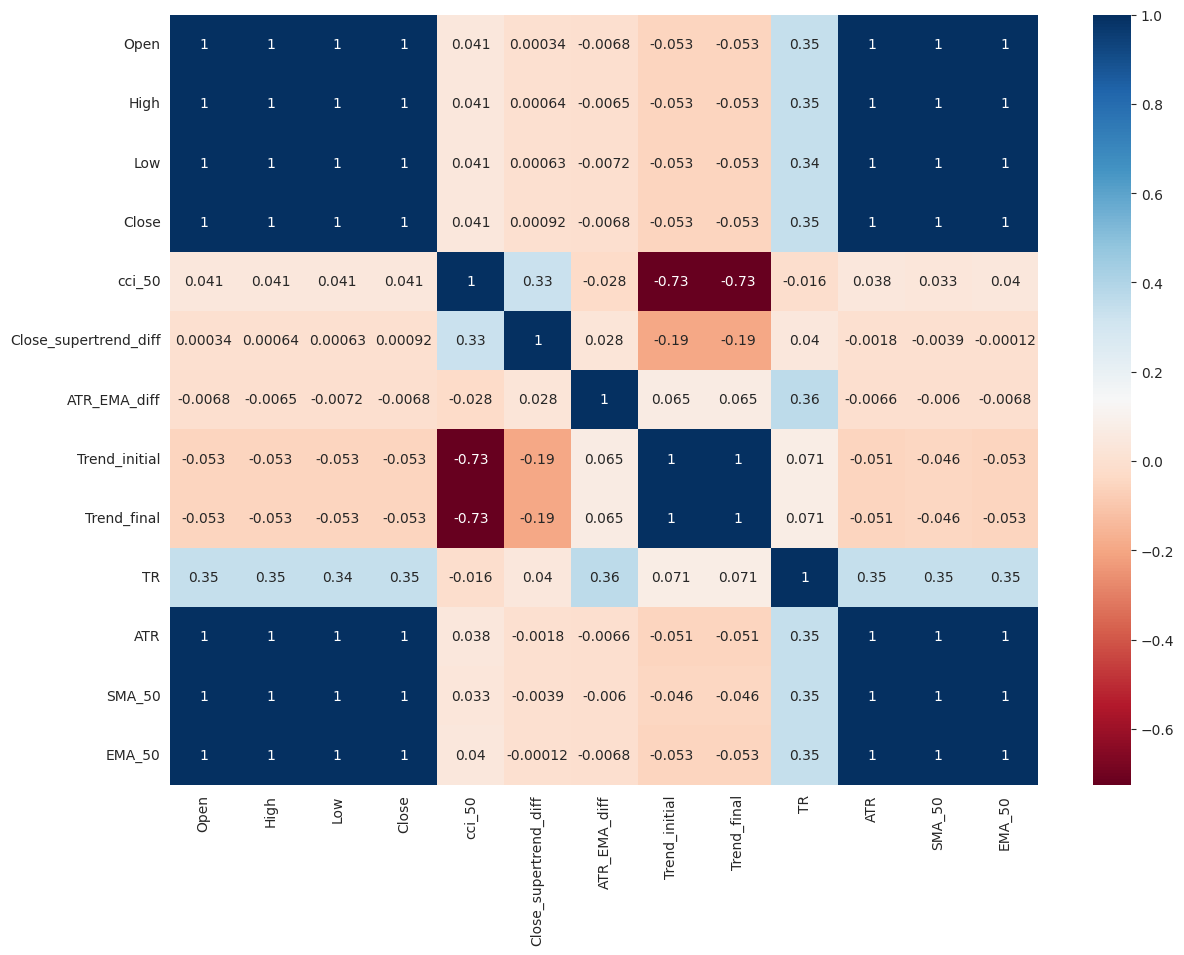

In [257]:
fig, axes = plt.subplots(1,1, figsize = (14,10))
numerical_fields = ['Open', 'High', 'Low', 'Close', 'cci_50',
                    'Close_supertrend_diff', 'ATR_EMA_diff', 'Trend_initial', 'Trend_final',
                    'TR', 'ATR', 'SMA_50', 'EMA_50']
sns.heatmap(df[numerical_fields].corr(), cmap="RdBu", annot=True, ax=axes)


1.   Open, Close, High, Low, ATR, SMA50, EMA50 are high correlated
2.   Trend initial and Trend Final are highly correlated
3.   Trend initial and Trend Final both have med to high negative correlated to CCI50
4.   Close, CCI50, TR, Close supertrend diff, ATR_EMA_diff can be used as features for the model
5.   Trend Final can be used as Target variable





# Features and Target

In [258]:
output_var = pd.DataFrame(df['Trend_final'])
features = ['Close', 'cci_50', 'Close_supertrend_diff', 'ATR_EMA_diff', 'TR']

# Scaling function

In [259]:
def variable_scaling( df, features, output_var):

  #Scaling
  scaler = MinMaxScaler()
  feature_transform = scaler.fit_transform(df[features])
  feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
  feature_transform.head()

  return feature_transform

# Time Series Data - Test Train Split Function

In [260]:
def Timeseries_Test_Train_split(feature_transform, output_var):


  #Splitting to Training set and Test set
  timesplit= TimeSeriesSplit(n_splits=5)
  i=0
  for train_index, test_index in timesplit.split(feature_transform):

    print(i, len(train_index), len(test_index))
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

    print(X_train.shape)

    #Process the data for LSTM
    X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test  = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

    i=i+1

  return X_train, X_test, y_train, y_test



# LSTM model development

In [261]:
def LSTM_model_training(X_train, y_train, _nepoch, _nbatchsize, _verbose):

  """
  ------------------------------------------------
  Building the LSTM Model
  ------------------------------------------------
  """


  lstm = Sequential()
  lstm.add(LSTM(10, input_shape=(1, X_train.shape[2]), activation='sigmoid', return_sequences=False))
  lstm.add(Dense(1, activation='sigmoid'))
  lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(lstm.summary())

  timestamp = str(datetime.datetime.now())[:13].replace(' ','_H')
  modelfilename = 'model/cnn_lstm_rating_'+timestamp+'.h5'
  modelfilename = os.path.join(cwdir,DrivePath,modelfilename)
  print("Filepath :", modelfilename)

  callbacks_lstm = [callbacks.EarlyStopping(monitor='acc', patience=3),
                    callbacks.ModelCheckpoint(filepath=modelfilename, monitor='val_loss', save_best_only=True)
                   ]

  history = lstm.fit(X_train, y_train, epochs= _nepoch, batch_size= _nbatchsize, verbose=_verbose, shuffle=False, callbacks=callbacks_lstm)

  return lstm

# Classification report generating function

In [262]:
def generate_classification_report(_model, X_test, y_test ):
  testPredict = _model.predict(X_test)
  yPred = testPredict.ravel()

  yPred_ = []
  for v in yPred:
    if v>=0.5:
      yPred_.append(1)
    else:
      yPred_.append(0)

  print(classification_report(yPred_, y_test))
  return yPred_

# Main Block to call all functions

In [263]:

def main():

  feature_transform = variable_scaling(df, features, output_var)

  X_train, X_test, y_train, y_test = Timeseries_Test_Train_split(feature_transform, output_var)

  LSTM_model = LSTM_model_training(X_train, y_train, _nepoch=10, _nbatchsize=8, _verbose=1)

  scores = LSTM_model.evaluate(X_test, y_test, verbose=1)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  generate_classification_report(LSTM_model, X_test, y_test )

  return LSTM_model

# Run the script

In [264]:

if __name__ == "__main__":
    # Execute the main function if the script is run directly
    LSTM_model = main()

0 35080 35079
(35080, 5)
1 70159 35079
(70159, 5)
2 105238 35079
(105238, 5)
3 140317 35079
(140317, 5)
4 175396 35079
(175396, 5)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10)                640       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 651 (2.54 KB)
Trainable params: 651 (2.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Filepath : /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/model/cnn_lstm_rating_2024-06-09_H14.h5
Epoch 1/10
21912/21925 [============================>.] - ETA: 0s - loss: 0.6389 - accuracy: 0.6506

21925/21925 [==============================] - 83s 4ms/step - loss: 0.6389 - accuracy: 0.6506
Epoch 2/10
21913/21925 [============================>.] - ETA: 0s - loss: 0.6032 - accuracy: 0.6650

21925/21925 [==============================] - 81s 4ms/step - loss: 0.6032 - accuracy: 0.6650
Epoch 3/10
21912/21925 [============================>.] - ETA: 0s - loss: 0.5361 - accuracy: 0.7282

21925/21925 [==============================] - 81s 4ms/step - loss: 0.5361 - accuracy: 0.7283
Epoch 4/10
21916/21925 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.8041

21925/21925 [==============================] - 81s 4ms/step - loss: 0.4574 - accuracy: 0.8041
Epoch 5/10
21912/21925 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8471

21925/21925 [==============================] - 80s 4ms/step - loss: 0.3912 - accuracy: 0.8471
Epoch 6/10
21920/21925 [============================>.] - ETA: 0s - loss: 0.3445 - accuracy: 0.8679

21925/21925 [==============================] - 81s 4ms/step - loss: 0.3445 - accuracy: 0.8679
Epoch 7/10
21925/21925 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8786

21925/21925 [==============================] - 81s 4ms/step - loss: 0.3139 - accuracy: 0.8786
Epoch 8/10
21918/21925 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8842

21925/21925 [==============================] - 80s 4ms/step - loss: 0.2941 - accuracy: 0.8842
Epoch 9/10
21919/21925 [============================>.] - ETA: 0s - loss: 0.2811 - accuracy: 0.8877

21925/21925 [==============================] - 81s 4ms/step - loss: 0.2811 - accuracy: 0.8877
Epoch 10/10
21914/21925 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8903

1097/1097 [==============================] - 2s 2ms/step - loss: 0.2867 - accuracy: 0.8865
Accuracy: 88.65%
1097/1097 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     23337
           1       0.85      0.80      0.82     11742

    accuracy                           0.89     35079
   macro avg       0.88      0.86      0.87     35079
weighted avg       0.89      0.89      0.89     35079



# Example of Recommendation in Production

In [183]:
df.head(3)

,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50
40,04/01/11 13:15,6148.75,6160.30,6148.60,6160.3,88.98,0.0,0.58,0,0,2011-01-04 13:15:00,2011-01-04,1,4,2011,1,1,1,13,15,11.70,6145.835714,6143.019512,6149.921593
41,04/01/11 13:20,6160.05,6172.65,6159.15,6172.0,182.63,0.0,0.45,0,0,2011-01-04 13:20:00,2011-01-04,1,4,2011,1,1,1,13,20,13.50,6147.846429,6143.709524,6157.281063
42,04/01/11 13:25,6172.00,6172.35,6160.90,6164.4,158.95,0.0,0.49,0,0,2011-01-04 13:25:00,2011-01-04,1,4,2011,1,1,1,13,25,11.45,6149.028571,6144.190698,6159.654042


In [184]:
df_trendfinal = df.groupby(['date'])['Trend_final'].sum().reset_index()
df_trendfinal[df_trendfinal.Trend_final.between(30,50)].tail(3)['date'].unique()

array([datetime.date(2024, 4, 19), datetime.date(2024, 5, 2),
       datetime.date(2024, 5, 29)], dtype=object)

In [185]:
d = '2024-05-29'

In [214]:
data = df[df.date.astype('datetime64[ns]').dt.strftime('%Y-%m-%d')==d]

,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50,Close_TrendFinal
246684,29/05/24 9:20,22782.05,22821.45,22773.95,22779.35,-418.53,0.0,5.16,1,1,2024-05-29 09:20:00,2024-05-29,2,29,2024,2,5,22,9,20,47.50,22891.014286,22924.582,22847.727473,22779.35
246685,29/05/24 9:25,22779.35,22806.75,22773.00,22806.75,-353.86,0.0,5.60,1,1,2024-05-29 09:25:00,2024-05-29,2,29,2024,2,5,22,9,25,33.75,22882.810714,22921.660,22834.068315,22806.75
246686,29/05/24 9:30,22806.75,22816.10,22795.45,22798.10,-293.58,0.0,5.21,1,1,2024-05-29 09:30:00,2024-05-29,2,29,2024,2,5,22,9,30,20.65,22874.560714,22918.572,22822.078877,22798.10


In [215]:
X_try_feature_transform = variable_scaling(data, features, output_var)
X_try = np.array(X_try_feature_transform).reshape(X_try_feature_transform.shape[0], 1, X_try_feature_transform.shape[1])
y_try = pd.DataFrame(data['Trend_final']).values.ravel()

In [216]:
X_try.shape

(75, 1, 13)

In [217]:
y_try_pred = generate_classification_report(LSTM_model, X_try, y_try)

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        61
           1       0.29      1.00      0.44        14

    accuracy                           0.53        75
   macro avg       0.64      0.71      0.52        75
weighted avg       0.87      0.53      0.57        75



In [226]:
data = pd.merge(data, pd.DataFrame(y_try_pred, columns=['predicted_TrendFinal']), on=data.index, how='left')
data.head(3)

,key_0,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50,Close_TrendFinal,predicted_TrendFinal
0,246684,29/05/24 9:20,22782.05,22821.45,22773.95,22779.35,-418.53,0.0,5.16,1,1,2024-05-29 09:20:00,2024-05-29,2,29,2024,2,5,22,9,20,47.50,22891.014286,22924.582,22847.727473,22779.35,1
1,246685,29/05/24 9:25,22779.35,22806.75,22773.00,22806.75,-353.86,0.0,5.60,1,1,2024-05-29 09:25:00,2024-05-29,2,29,2024,2,5,22,9,25,33.75,22882.810714,22921.660,22834.068315,22806.75,1
2,246686,29/05/24 9:30,22806.75,22816.10,22795.45,22798.10,-293.58,0.0,5.21,1,1,2024-05-29 09:30:00,2024-05-29,2,29,2024,2,5,22,9,30,20.65,22874.560714,22918.572,22822.078877,22798.10,1


In [238]:
data['Close_TrendFinal'] = np.where(data['Trend_final']==1, data['Close']*(1-0.0003), np.nan)
data['Close_Precicted_TrendFinal'] = np.where(data['predicted_TrendFinal']==1, data['Close']*(1+0.0003), np.nan)
data.head(3)

,key_0,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50,Close_TrendFinal,predicted_TrendFinal,Close_Precicted_TrendFinal
0,246684,29/05/24 9:20,22782.05,22821.45,22773.95,22779.35,-418.53,0.0,5.16,1,1,2024-05-29 09:20:00,2024-05-29,2,29,2024,2,5,22,9,20,47.50,22891.014286,22924.582,22847.727473,22772.516195,1,22786.183805
1,246685,29/05/24 9:25,22779.35,22806.75,22773.00,22806.75,-353.86,0.0,5.60,1,1,2024-05-29 09:25:00,2024-05-29,2,29,2024,2,5,22,9,25,33.75,22882.810714,22921.660,22834.068315,22799.907975,1,22813.592025
2,246686,29/05/24 9:30,22806.75,22816.10,22795.45,22798.10,-293.58,0.0,5.21,1,1,2024-05-29 09:30:00,2024-05-29,2,29,2024,2,5,22,9,30,20.65,22874.560714,22918.572,22822.078877,22791.260570,1,22804.939430


The below plot shows trend curve for a specific day - '2024-05-29'


*   Close (blue)
*   EMA50 (green)
*   upward trend positions - actual (red)
*   upward trend positions - predicted (purple)


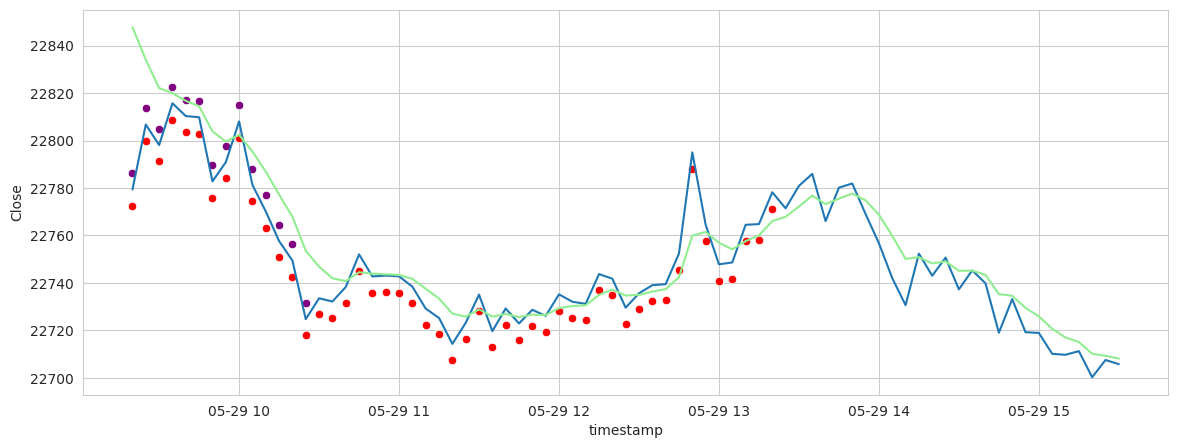

In [274]:

fig, axes = plt.subplots(1,1, figsize = (14,5))
sns.lineplot(data=data, x='timestamp', y='Close', ax=axes)
sns.lineplot(data=data, x='timestamp', y='EMA_50', ax=axes, color='lightgreen')
sns.scatterplot(data=data, x='timestamp', y='Close_TrendFinal', ax=axes, color='red')
sns.scatterplot(data=data, x='timestamp', y='Close_Precicted_TrendFinal', ax=axes, color='purple')
plt.show()

# Code Ends